In [35]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import torch as torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.optim import AdamW, LBFGS
from torch import GradScaler
from scipy.linalg import expm
from scipy.optimize import minimize

In [2]:
# One-qubit operators
sigma_x = torch.tensor([[0., 1.], [1., 0.]], dtype=torch.complex64)
sigma_y = torch.tensor([[0., -1j], [1j, 0.]], dtype=torch.complex64)
sigma_z = torch.tensor([[1., 0.], [0., -1.]], dtype=torch.complex64)
identity = torch.eye(2, dtype=torch.complex64)
# Two-qubit operators
# Qubit 1 controls
sx1 = torch.kron(sigma_x, identity)  # σₓ ⊗ I
sz1 = torch.kron(sigma_z, identity)  # σ_z ⊗ I
# Qubit 2 controls
sx2 = torch.kron(identity, sigma_x)  # I ⊗ σₓ
sz2 = torch.kron(identity, sigma_z)  # I ⊗ σ_z
# Coupling
szx = torch.kron(sigma_z, sigma_x)  # σ_z ⊗ σ_x

In [3]:
H_target = (1/np.sqrt(2)) * torch.tensor([[1., 1.], [1., -1.]], dtype=torch.complex64)
T_target = torch.tensor([[1., 0.], [0., np.exp(1j * np.pi / 4)]], dtype=torch.complex64)
CNOT_target = torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
], dtype=torch.complex64)

In [4]:
# System parameters
T_total = 1.0    # total time
N = 9           # number of time steps
dt = 1/9 # delta time
time_grid = torch.linspace(0, T_total, N)
K = 5
freqs = torch.linspace(1.0, 5.0, K)
omega0 = 2 * np.pi / T_total

In [5]:
# GRAPE
def propagate_grape(params, target):
  if target.shape[0] == 2:
    u_x = params['ux']
    u_z = params['uz']
    U = torch.eye(2, dtype=torch.complex64)
    for n in range(N):
      H = u_x[n] * sigma_x + u_z[n] * sigma_z
      U_step = torch.matrix_exp(-1j * H * dt)
      U = U_step @ U
  else:
    u1x = params['u1x']
    u1z = params['u1z']
    u2x = params['u2x']
    u2z = params['u2z']
    jzx = params['jzx']
    U = torch.eye(4, dtype=torch.complex64)
    for n in range(N):
      H = jzx[n] * szx + u1x[n] * sx1 + u1z[n] * sz1 + u2x[n] * sx2 + u2z[n] * sz2
      U_step = torch.matrix_exp(-1j * H * dt)
      U = U_step @ U
  return U

def process_fidelity_grape(U, U_target):
    dim = U_target.shape[0]
    fidelity = torch.clamp((torch.abs(torch.trace(U_target.conj().T @ U) / dim))**2, 0, 1)
    infidelity = torch.log10(1 - fidelity)
    return fidelity.item(), infidelity.item()

def loss_fn_grape(U, U_target):
    # Compute the global phase factor from the trace overlap
    trace_val = torch.trace(U_target.conj().T @ U)
    # Add a small constant to avoid division by zero
    phase = torch.angle(trace_val + 1e-8)
    # Phase factor to cancel the global phase
    phase_factor = torch.exp(-1j * phase)
    U_aligned = U * phase_factor
    diff = U_target - U_aligned
    loss = torch.norm(diff, p='fro')**2
    return loss

def train_grape(iters, optimizer, params, target):
  scaler = GradScaler('cpu')
  loss_list, fid_list, inf_list = [], [], []
  for it in range(iters):
    optimizer.zero_grad(set_to_none=True)
    U = propagate_grape(params, target)
    loss = loss_fn_grape(U, target)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    fid, inf = process_fidelity_grape(U, target)
    loss_list.append(loss.item())
    fid_list.append(fid)
    inf_list.append(inf)
    if it % 100 == 0 or it == num_iters-1:
        print(f"Iteration {it}: Loss = {loss.item()}")
        print(f"Fidelity = {fid}, Infidelity = {inf}")
  return loss_list, fid_list, inf_list

In [6]:
# CRAB
def process_fidelity_crab(U, U_target):
    dim = U_target.shape[0]
    fidelity = np.clip((np.abs(np.trace(U_target.conj().T @ U) / dim))**2, 0, 1)
    infidelity = np.log10(1 - fidelity)
    return fidelity.item(), infidelity.item()

def drive_control(t, x):
    # x[0:K]: alpha coefficients, x[K:2K]: beta coefficients.
    alphas = x[:K]
    betas = x[K:2*K]
    pulse = 0.0
    for k in range(1, K+1):
        pulse += alphas[k-1] * np.cos(k * omega0 * t) + betas[k-1] * np.sin(k * omega0 * t)
    return pulse

def detuning_control(t, x):
    # x[2K:3K]: gamma coefficients, x[3K:4K]: delta coefficients.
    gammas = x[2*K:3*K]
    deltas = x[3*K:4*K]
    pulse = 0.0
    for k in range(1, K+1):
        pulse += gammas[k-1] * np.cos(k * omega0 * t) + deltas[k-1] * np.sin(k * omega0 * t)
    return pulse

# Total control pulse applied in the Hamiltonian.
# H(t) = εₓ(t) σ_x + ε_z(t) σ_z.
def hamiltonian(t, x):
    eps_x = drive_control(t, x)
    eps_z = detuning_control(t, x)
    return eps_x * sigma_x + eps_z * sigma_z

def propagate_crab(x):
  U = np.eye(2).copy()
  for t in time_grid:
    H = hamiltonian(t, x)
    U_step = expm(-1j * H * dt)
    U = U_step @ U
  return U

In [7]:
ux_grape_h_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
uz_grape_h_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
params = {'ux': ux_grape_h_adam, 'uz': uz_grape_h_adam}
optimizer = AdamW([ux_grape_h_adam, uz_grape_h_adam], lr=0.001, weight_decay=0.001)

In [8]:
num_iters = 3000
loss_list_grape_h_adam, fid_list_grape_h_adam, inf_list_grape_h_adam = train_grape(num_iters, optimizer, params, H_target)

Iteration 0: Loss = 3.7945315837860107
Fidelity = 0.002638577949255705, Infidelity = -0.0011474344646558166
Iteration 100: Loss = 3.247995138168335
Fidelity = 0.03534441068768501, Infidelity = -0.015627719461917877
Iteration 200: Loss = 2.724512815475464
Fidelity = 0.10167929530143738, Infidelity = -0.0465686060488224
Iteration 300: Loss = 2.238957166671753
Fidelity = 0.19382932782173157, Infidelity = -0.09357298910617828
Iteration 400: Loss = 1.8024489879608154
Fidelity = 0.3018268942832947, Infidelity = -0.1560368835926056
Iteration 500: Loss = 1.421789526939392
Fidelity = 0.4154478907585144, Infidelity = -0.23317676782608032
Iteration 600: Loss = 1.0994669198989868
Fidelity = 0.5258180499076843, Infidelity = -0.3240549862384796
Iteration 700: Loss = 0.8341785669326782
Fidelity = 0.626401424407959, Infidelity = -0.42759478092193604
Iteration 800: Loss = 0.6216849684715271
Fidelity = 0.7133128643035889, Infidelity = -0.5425918102264404
Iteration 900: Loss = 0.4558044672012329
Fidelity

In [9]:
ux_grape_h_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
uz_grape_h_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
params = {'ux': ux_grape_h_lbfgs, 'uz': uz_grape_h_lbfgs}

loss_list_grape_h_lbfgs, fid_list_grape_h_lbfgs, inf_list_grape_h_lbfgs = [], [], []

def closure():
  optimizer.zero_grad(set_to_none=True)
  U = propagate_grape(params, H_target)
  loss = loss_fn_grape(U, H_target)
  loss.backward()
  fid, inf = process_fidelity_grape(U, H_target)
  loss_list_grape_h_lbfgs.append(loss.item())
  fid_list_grape_h_lbfgs.append(fid)
  inf_list_grape_h_lbfgs.append(inf)
  return loss

optimizer = LBFGS([ux_grape_h_lbfgs , uz_grape_h_lbfgs], lr=0.001, max_iter=10)

num_iterations = 300
for i in range(num_iterations):
  loss = optimizer.step(closure)
  if i % 10 == 0 or i == num_iterations - 1:
    print(f"Iteration {i}, Loss: {loss.item()}")
    print(f"Fidelity: {fid_list_grape_h_lbfgs[-1]}, Infidelity: {inf_list_grape_h_lbfgs[-1]}")

Iteration 0, Loss: 3.672612190246582
Fidelity: 0.07420653104782104, Infidelity: -0.033485885709524155
Iteration 10, Loss: 1.4680700302124023
Fidelity: 0.41850945353507996, Infidelity: -0.23545736074447632
Iteration 20, Loss: 0.7300731539726257
Fidelity: 0.6922512054443359, Infidelity: -0.5118036270141602
Iteration 30, Loss: 0.31052306294441223
Fidelity: 0.8625253438949585, Infidelity: -0.8617773652076721
Iteration 40, Loss: 0.13060234487056732
Fidelity: 0.9396352171897888, Infidelity: -1.2192163467407227
Iteration 50, Loss: 0.04173519089818001
Fidelity: 0.9814748167991638, Infidelity: -1.732237458229065
Iteration 60, Loss: 0.013907085172832012
Fidelity: 0.9936314225196838, Infidelity: -2.195957660675049
Iteration 70, Loss: 0.004928466398268938
Fidelity: 0.9977394938468933, Infidelity: -2.64579439163208
Iteration 80, Loss: 0.002075407188385725
Fidelity: 0.9990322589874268, Infidelity: -3.0142407417297363
Iteration 90, Loss: 0.000941951060667634
Fidelity: 0.9995577931404114, Infidelity: 

In [10]:
loss_list_crab_h, fid_list_crab_h, inf_list_crab_h = [], [], []

def loss_fn_crab(x):
    U = propagate_crab(x)
    # Compute the global phase factor from the trace overlap
    trace_val = np.trace(H_target.numpy().conj().T @ U)
    # Add a small constant to avoid division by zero
    phase = np.angle(trace_val + 1e-8)
    # Phase factor to cancel the global phase
    phase_factor = np.exp(-1j * phase)
    U_aligned = U * phase_factor
    diff = H_target.numpy() - U_aligned
    loss = np.linalg.norm(diff, ord='fro')**2
    loss_list_crab_h.append(loss)
    fid, inf = process_fidelity_crab(U_aligned, H_target.numpy())
    fid_list_crab_h.append(fid)
    inf_list_crab_h.append(inf)
    return loss

In [11]:
x0 = np.random.randn(4 * K)
res = minimize(loss_fn_crab, x0, method='Nelder-Mead', options={'maxiter': 5000, 'disp': True})# Optimize using Nelder-Mead.

/tmp/ipykernel_1481481/488501137.py:5: RuntimeWarning: divide by zero encountered in log10
  infidelity = np.log10(1 - fidelity)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 968
         Function evaluations: 1375


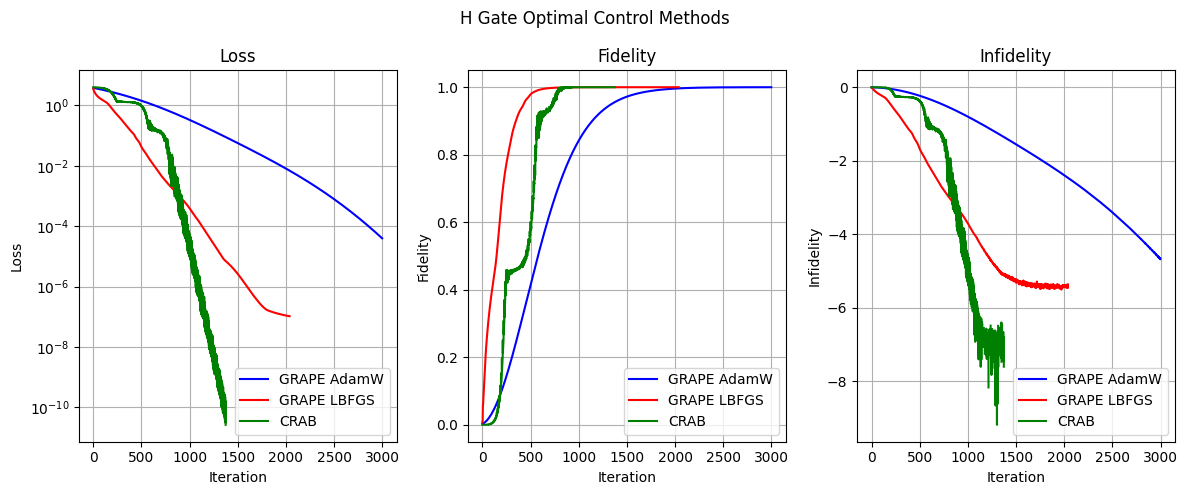

In [12]:
# plot loss, fid, inf
plt.figure(figsize=(12, 5))
plt.suptitle("H Gate Optimal Control Methods")
plt.subplot(1, 3, 1)
plt.plot(loss_list_grape_h_adam, label='GRAPE AdamW', color='blue')
plt.plot(loss_list_grape_h_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(loss_list_crab_h, label='CRAB', color='green')
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(fid_list_grape_h_adam, label='GRAPE AdamW', color='blue')
plt.plot(fid_list_grape_h_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(fid_list_crab_h, label='CRAB', color='green')
plt.title('Fidelity')
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.legend()
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(inf_list_grape_h_adam, label='GRAPE AdamW', color='blue')
plt.plot(inf_list_grape_h_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(inf_list_crab_h, label='CRAB', color='green')
plt.title('Infidelity')
plt.xlabel('Iteration')
plt.ylabel('Infidelity')
plt.legend()
plt.grid()
plt.savefig(
    "/home/pdconte/Desktop/DUTh_Thesis/Plots/H_Gate_Optimal_Control_Methods.png"
)
plt.tight_layout()
plt.show()

In [13]:
pd.DataFrame({'loss_grape_h_adam': loss_list_grape_h_adam, 'fid_grape_h_adam': fid_list_grape_h_adam, 'inf_grape_h_adam': inf_list_grape_h_adam}).to_csv('grape_h_adam.csv')
pd.DataFrame({'loss_grape_h_lbfgs': loss_list_grape_h_lbfgs, 'fid_grape_h_lbfgs': fid_list_grape_h_lbfgs, 'inf_grape_h_lbfgs': inf_list_grape_h_lbfgs}).to_csv('grape_h_lbfgs.csv')
pd.DataFrame({'loss_crab_h': loss_list_crab_h, 'fid_crab_h': fid_list_crab_h, 'inf_crab_h': inf_list_crab_h}).to_csv('crab_h.csv')

In [14]:
# Plot the optimized control pulses
time_edges = np.linspace(0, T_total, N+1)
ux_grape_h_adam = ux_grape_h_adam.detach().cpu().numpy()
uz_grape_h_adam = uz_grape_h_adam.detach().cpu().numpy()
ux_grape_h_lbfgs = ux_grape_h_lbfgs.detach().cpu().numpy()
uz_grape_h_lbfgs = uz_grape_h_lbfgs.detach().cpu().numpy()

x_opt = res.x
ux_grape_h_crab = [drive_control(t, x_opt) for t in time_grid]
uz_grape_h_crab = [detuning_control(t, x_opt) for t in time_grid]

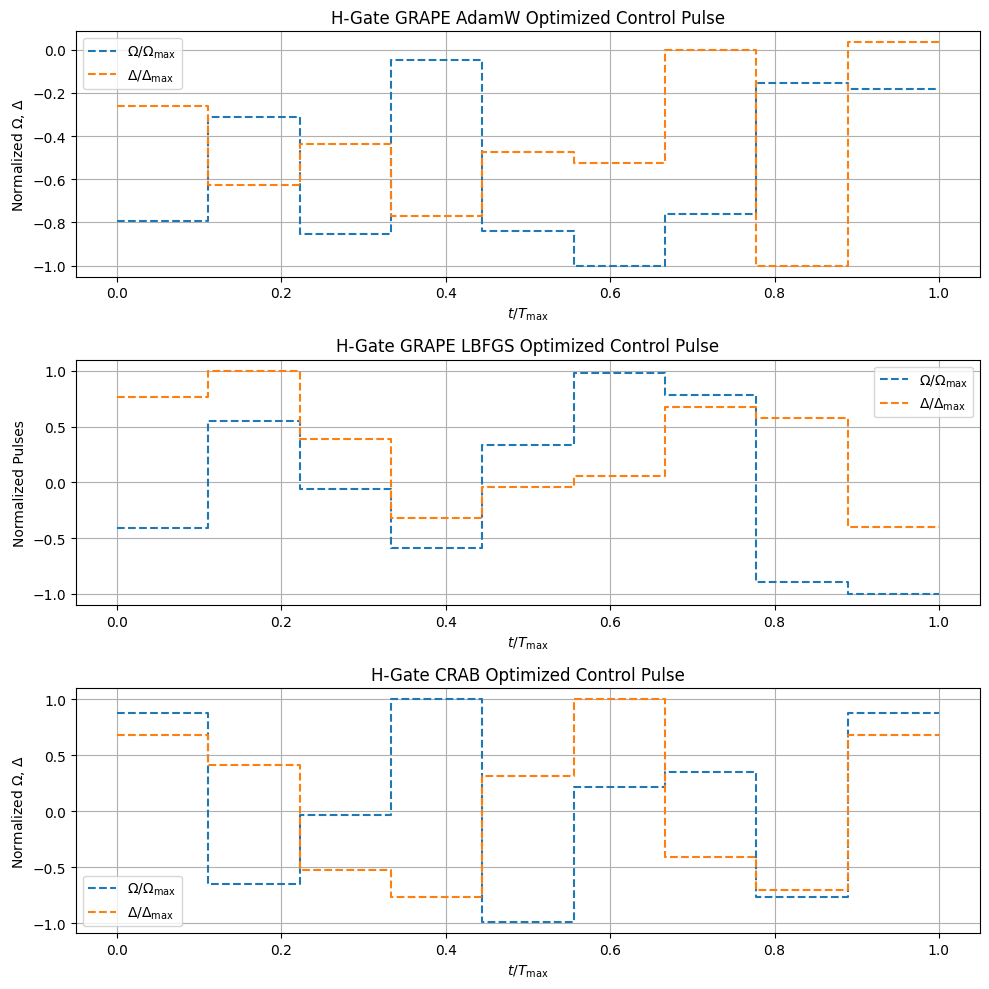

In [15]:
# Define a normalization function
def normalize(arr):
    return arr / np.max(np.abs(arr))


# Normalize the data arrays
ux_grape_h_adam_norm = normalize(ux_grape_h_adam)
uz_grape_h_adam_norm = normalize(uz_grape_h_adam)
ux_grape_h_lbfgs_norm = normalize(ux_grape_h_lbfgs)
uz_grape_h_lbfgs_norm = normalize(uz_grape_h_lbfgs)
ux_grape_h_crab_norm = normalize(ux_grape_h_crab)
uz_grape_h_crab_norm = normalize(uz_grape_h_crab)

# Normalize the time axis as t/Tmax, where Tmax is the final time value
Tmax = time_edges[-1]
t_normalized = time_edges / Tmax

plt.figure(figsize=(10, 10))

# GRAPE AdamW Plot
plt.subplot(3, 1, 1)
plt.step(
    t_normalized,
    np.append(ux_grape_h_adam_norm, ux_grape_h_adam_norm[-1]),
    where="post",
    label=r"$\Omega/\Omega_{\max}$",
    linestyle="--",
)
plt.step(
    t_normalized,
    np.append(uz_grape_h_adam_norm, uz_grape_h_adam_norm[-1]),
    where="post",
    label=r"$\Delta/\Delta_{\max}$",
    linestyle="--",
)
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel(r"Normalized $\Omega$, $\Delta$")
plt.title("H-Gate GRAPE AdamW Optimized Control Pulse")
plt.legend()
plt.grid(True)

# GRAPE LBFGS Plot
plt.subplot(3, 1, 2)
plt.step(
    t_normalized,
    np.append(ux_grape_h_lbfgs_norm, ux_grape_h_lbfgs_norm[-1]),
    where="post",
    label=r"$\Omega/\Omega_{\max}$",
    linestyle="--",
)
plt.step(
    t_normalized,
    np.append(uz_grape_h_lbfgs_norm, uz_grape_h_lbfgs_norm[-1]),
    where="post",
    label=r"$\Delta/\Delta_{\max}$",
    linestyle="--",
)
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel(r"Normalized Pulses")
plt.title("H-Gate GRAPE LBFGS Optimized Control Pulse")
plt.legend()
plt.grid(True)

# CRAB Plot
plt.subplot(3, 1, 3)
plt.step(
    t_normalized,
    np.append(ux_grape_h_crab_norm, ux_grape_h_crab_norm[-1]),
    where="post",
    label=r"$\Omega/\Omega_{\max}$",
    linestyle="--",
)
plt.step(
    t_normalized,
    np.append(uz_grape_h_crab_norm, uz_grape_h_crab_norm[-1]),
    where="post",
    label=r"$\Delta/\Delta_{\max}$",
    linestyle="--",
)
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel(r"Normalized $\Omega$, $\Delta$")
plt.title("H-Gate CRAB Optimized Control Pulse")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(
    "/home/pdconte/Desktop/DUTh_Thesis/Plots/H_Gate_Optimal_Control_Pulses_Normalized.png"
)
plt.show()

In [1]:
# T-Gate
N = 10
dt = 1/10
time_grid = torch.linspace(0, T_total, N)
ux_grape_t_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
uz_grape_t_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
params = {'ux': ux_grape_t_adam, 'uz': uz_grape_t_adam}
optimizer = AdamW([ux_grape_t_adam, uz_grape_t_adam], lr=0.001, weight_decay=0.001)

NameError: name 'torch' is not defined

In [17]:
num_iters = 1200
loss_list_grape_t_adam, fid_list_grape_t_adam, inf_list_grape_t_adam = train_grape(num_iters, optimizer, params, T_target)

Iteration 0: Loss = 0.016737423837184906
Fidelity = 0.9916478395462036, Infidelity = -2.0782010555267334
Iteration 100: Loss = 0.0004962030216120183
Fidelity = 0.999751091003418, Infidelity = -3.603959321975708
Iteration 200: Loss = 4.676819855831127e-07
Fidelity = 0.9999994039535522, Infidelity = -6.224720001220703
Iteration 300: Loss = 3.64043489797794e-10
Fidelity = 0.9999991655349731, Infidelity = -6.078591823577881
Iteration 400: Loss = 2.0856601168350863e-10
Fidelity = 0.9999994039535522, Infidelity = -6.224720001220703
Iteration 500: Loss = 1.5633663807967935e-10
Fidelity = 0.9999994039535522, Infidelity = -6.224720001220703
Iteration 600: Loss = 1.2256977377500533e-10
Fidelity = 0.9999991655349731, Infidelity = -6.078591823577881
Iteration 700: Loss = 9.745486362344735e-11
Fidelity = 0.999998927116394, Infidelity = -5.969447612762451
Iteration 800: Loss = 8.104794613217337e-11
Fidelity = 0.999998927116394, Infidelity = -5.969447612762451
Iteration 900: Loss = 6.77581463159882e-

In [18]:
ux_grape_t_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
uz_grape_t_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
params = {'ux': ux_grape_t_lbfgs, 'uz': uz_grape_t_lbfgs}

loss_list_grape_t_lbfgs, fid_list_grape_t_lbfgs, inf_list_grape_t_lbfgs = [], [], []

def closure():
  optimizer.zero_grad(set_to_none=True)
  U = propagate_grape(params, T_target)
  loss = loss_fn_grape(U, T_target)
  loss.backward()
  fid, inf = process_fidelity_grape(U, T_target)
  loss_list_grape_t_lbfgs.append(loss.item())
  fid_list_grape_t_lbfgs.append(fid)
  inf_list_grape_t_lbfgs.append(inf)
  return loss

optimizer = LBFGS([ux_grape_t_lbfgs , uz_grape_t_lbfgs], lr=0.001, max_iter=10)

num_iterations = 120
for i in range(num_iterations):
  loss = optimizer.step(closure)
  if i % 10 == 0 or i == num_iterations - 1:
    print(f"Iteration {i}, Loss: {loss.item()}")
    print(f"Fidelity: {fid_list_grape_t_lbfgs[-1]}, Infidelity: {inf_list_grape_t_lbfgs[-1]}")

Iteration 0, Loss: 1.6055988073349
Fidelity: 0.37106436491012573, Infidelity: -0.20139379799365997
Iteration 10, Loss: 0.7792521715164185
Fidelity: 0.6631838083267212, Infidelity: -0.4726070463657379
Iteration 20, Loss: 0.37104010581970215
Fidelity: 0.8353788256645203, Infidelity: -0.7835143208503723
Iteration 30, Loss: 0.1618347465991974
Fidelity: 0.9260838031768799, Infidelity: -1.1312603950500488
Iteration 40, Loss: 0.07567990571260452
Fidelity: 0.9652531147003174, Infidelity: -1.459084153175354
Iteration 50, Loss: 0.03679576888680458
Fidelity: 0.9828668832778931, Infidelity: -1.7661635875701904
Iteration 60, Loss: 0.016434578225016594
Fidelity: 0.9926226735115051, Infidelity: -2.132101058959961
Iteration 70, Loss: 0.005345229059457779
Fidelity: 0.9975369572639465, Infidelity: -2.6085281372070312
Iteration 80, Loss: 0.0016511839348822832
Fidelity: 0.9992434978485107, Infidelity: -3.121189832687378
Iteration 90, Loss: 0.0005476537044160068
Fidelity: 0.9997493028640747, Infidelity: -3

In [19]:
loss_list_crab_t, fid_list_crab_t, inf_list_crab_t = [], [], []

def loss_fn_crab(x):
    U = propagate_crab(x)
    # Compute the global phase factor from the trace overlap
    trace_val = np.trace(T_target.numpy().conj().T @ U)
    # Add a small constant to avoid division by zero
    phase = np.angle(trace_val + 1e-8)
    # Phase factor to cancel the global phase
    phase_factor = np.exp(-1j * phase)
    U_aligned = U * phase_factor
    diff = T_target.numpy() - U_aligned
    loss = np.linalg.norm(diff, ord='fro')**2
    loss_list_crab_t.append(loss)
    fid, inf = process_fidelity_crab(U_aligned, T_target.numpy())
    fid_list_crab_t.append(fid)
    inf_list_crab_t.append(inf)
    return loss

x0 = np.random.randn(4 * K)
res = minimize(loss_fn_crab, x0, method='Nelder-Mead', options={'maxiter': 5000, 'disp': True})# Optimize using Nelder-Mead.

/tmp/ipykernel_1481481/488501137.py:5: RuntimeWarning: divide by zero encountered in log10
  infidelity = np.log10(1 - fidelity)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 827
         Function evaluations: 1211


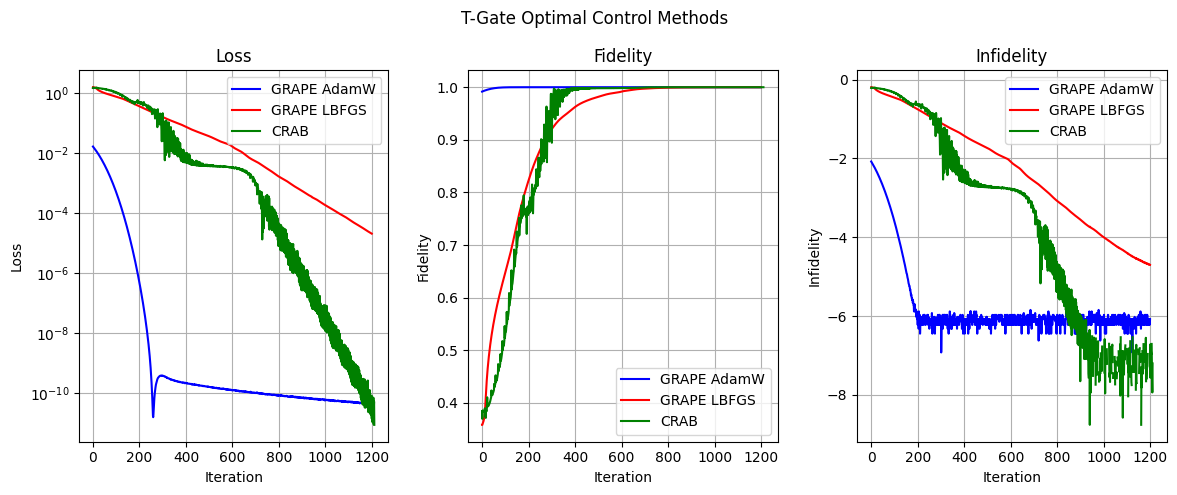

In [20]:
# plot loss, fid, inf
plt.figure(figsize=(12, 5))
plt.suptitle('T-Gate Optimal Control Methods')
plt.subplot(1, 3, 1)
plt.plot(loss_list_grape_t_adam, label='GRAPE AdamW', color='blue')
plt.plot(loss_list_grape_t_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(loss_list_crab_t, label='CRAB', color='green')
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(fid_list_grape_t_adam, label='GRAPE AdamW', color='blue')
plt.plot(fid_list_grape_t_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(fid_list_crab_t, label='CRAB', color='green')
plt.title('Fidelity')
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.legend()
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(inf_list_grape_t_adam, label='GRAPE AdamW', color='blue')
plt.plot(inf_list_grape_t_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(inf_list_crab_t, label='CRAB', color='green')
plt.title('Infidelity')
plt.xlabel('Iteration')
plt.ylabel('Infidelity')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('/home/pdconte/Desktop/DUTh_Thesis/Plots/T_Gate_Optimal_Control_Methods.png')
plt.show()

In [21]:
pd.DataFrame({'loss_grape_t_adam': loss_list_grape_t_adam, 'fid_grape_t_adam': fid_list_grape_t_adam, 'inf_grape_t_adam': inf_list_grape_t_adam}).to_csv('grape_t_adam.csv')
pd.DataFrame({'loss_grape_t_lbfgs': loss_list_grape_t_lbfgs, 'fid_grape_t_lbfgs': fid_list_grape_t_lbfgs, 'inf_grape_t_lbfgs': inf_list_grape_t_lbfgs}).to_csv('grape_t_lbfgs.csv')
pd.DataFrame({'loss_crab_t': loss_list_crab_t, 'fid_crab_t': fid_list_crab_t, 'inf_crab_t': inf_list_crab_t}).to_csv('crab_t.csv')

In [22]:
# Plot the optimized control pulses
time_edges = np.linspace(0, T_total, N+1)
ux_grape_t_adam = ux_grape_t_adam.detach().cpu().numpy()
uz_grape_t_adam = uz_grape_t_adam.detach().cpu().numpy()
ux_grape_t_lbfgs = ux_grape_t_lbfgs.detach().cpu().numpy()
uz_grape_t_lbfgs = uz_grape_t_lbfgs.detach().cpu().numpy()
x_opt = res.x
ux_grape_t_crab = [drive_control(t, x_opt) for t in time_grid]
uz_grape_t_crab = [detuning_control(t, x_opt) for t in time_grid]

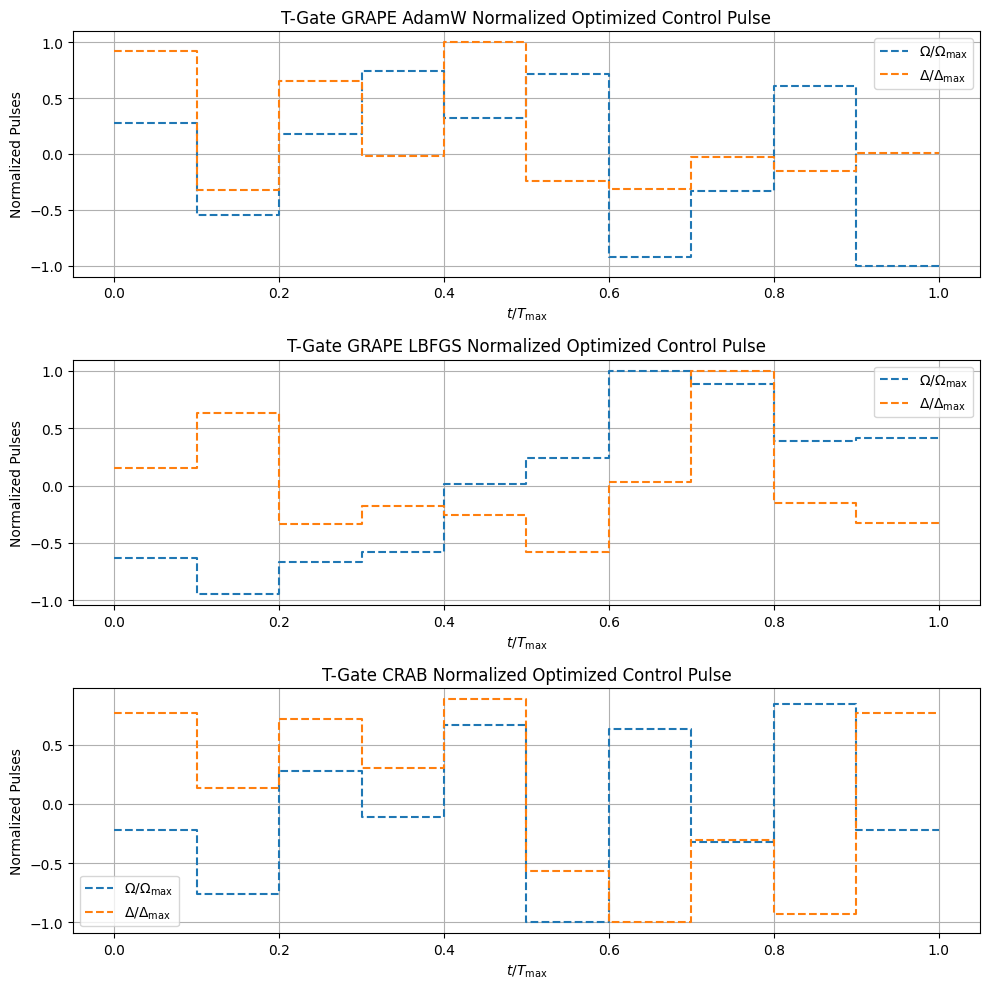

In [23]:
# Normalize the T-gate data arrays
ux_grape_t_adam_norm = normalize(ux_grape_t_adam)
uz_grape_t_adam_norm = normalize(uz_grape_t_adam)
ux_grape_t_lbfgs_norm = normalize(ux_grape_t_lbfgs)
uz_grape_t_lbfgs_norm = normalize(uz_grape_t_lbfgs)
ux_grape_t_crab_norm = normalize(ux_grape_t_crab)
uz_grape_t_crab_norm = normalize(uz_grape_t_crab)

# Normalize the time axis: t/Tmax (Tmax is the final time value)
Tmax = time_edges[-1]
t_normalized = time_edges / Tmax

plt.figure(figsize=(10, 10))

# GRAPE AdamW Plot for T-Gate
plt.subplot(3, 1, 1)
plt.step(
    t_normalized,
    np.append(ux_grape_t_adam_norm, ux_grape_t_adam_norm[-1]),
    where="post",
    label=r"$\Omega/\Omega_{\max}$",
    linestyle="--",
)
plt.step(
    t_normalized,
    np.append(uz_grape_t_adam_norm, uz_grape_t_adam_norm[-1]),
    where="post",
    label=r"$\Delta/\Delta_{\max}$",
    linestyle="--",
)
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel("Normalized Pulses")
plt.title("T-Gate GRAPE AdamW Normalized Optimized Control Pulse")
plt.legend()
plt.grid(True)

# GRAPE LBFGS Plot for T-Gate
plt.subplot(3, 1, 2)
plt.step(
    t_normalized,
    np.append(ux_grape_t_lbfgs_norm, ux_grape_t_lbfgs_norm[-1]),
    where="post",
    label=r"$\Omega/\Omega_{\max}$",
    linestyle="--",
)
plt.step(
    t_normalized,
    np.append(uz_grape_t_lbfgs_norm, uz_grape_t_lbfgs_norm[-1]),
    where="post",
    label=r"$\Delta/\Delta_{\max}$",
    linestyle="--",
)
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel("Normalized Pulses")
plt.title("T-Gate GRAPE LBFGS Normalized Optimized Control Pulse")
plt.legend()
plt.grid(True)

# CRAB Plot for T-Gate
plt.subplot(3, 1, 3)
plt.step(
    t_normalized,
    np.append(ux_grape_t_crab_norm, ux_grape_t_crab_norm[-1]),
    where="post",
    label=r"$\Omega/\Omega_{\max}$",
    linestyle="--",
)
plt.step(
    t_normalized,
    np.append(uz_grape_t_crab_norm, uz_grape_t_crab_norm[-1]),
    where="post",
    label=r"$\Delta/\Delta_{\max}$",
    linestyle="--",
)
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel("Normalized Pulses")
plt.title("T-Gate CRAB Normalized Optimized Control Pulse")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(
    "/home/pdconte/Desktop/DUTh_Thesis/Plots/T_Gate_Optimal_Control_Pulses_Normalized.png"
)
plt.show()

In [24]:
N = 5  # number of time steps
dt = 1/5  # delta time
time_grid = torch.linspace(0, T_total, N)

In [25]:
u1x_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 1: σₓ control
u1z_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 1: σ_z control
u2x_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 2: σₓ control
u2z_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 2: σ_z control
jzx_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Coupling Strength
params = {'u1x': u1x_grape_cnot_adam, 'u1z': u1z_grape_cnot_adam, 'u2x': u2x_grape_cnot_adam, 'u2z': u2z_grape_cnot_adam, 'jzx': jzx_grape_cnot_adam}
optimizer = AdamW([u1x_grape_cnot_adam, u1z_grape_cnot_adam, u2x_grape_cnot_adam, u2z_grape_cnot_adam, jzx_grape_cnot_adam], lr=0.001, weight_decay=0.001)

In [26]:
num_iters = 3000
loss_list_grape_cnot_adam, fid_list_grape_cnot_adam, inf_list_grape_cnot_adam = train_grape(num_iters, optimizer, params, CNOT_target)

Iteration 0: Loss = 5.3555707931518555
Fidelity = 0.10926558077335358, Infidelity = -0.050251759588718414
Iteration 100: Loss = 4.608526229858398
Fidelity = 0.1797201782464981, Infidelity = -0.08603796362876892
Iteration 200: Loss = 3.9529707431793213
Fidelity = 0.2559131383895874, Infidelity = -0.12837636470794678
Iteration 300: Loss = 3.121629476547241
Fidelity = 0.3718512952327728, Infidelity = -0.20193755626678467
Iteration 400: Loss = 2.159073829650879
Fidelity = 0.5330690145492554, Infidelity = -0.3307473063468933
Iteration 500: Loss = 1.372327208518982
Fidelity = 0.6863444447517395, Infidelity = -0.5035470128059387
Iteration 600: Loss = 0.8317111730575562
Fidelity = 0.802880585193634, Infidelity = -0.7052705883979797
Iteration 700: Loss = 0.4849432110786438
Fidelity = 0.8824384808540344, Infidelity = -0.9297348260879517
Iteration 800: Loss = 0.2712693214416504
Fidelity = 0.9333317875862122, Infidelity = -1.1760811805725098
Iteration 900: Loss = 0.14522069692611694
Fidelity = 0.9

In [27]:
u1x_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 1: σₓ control
u1z_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 1: σ_z control
u2x_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 2: σₓ control
u2z_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 2: σ_z control
jzx_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Coupling Strength
params = {'u1x': u1x_grape_cnot_lbfgs, 'u1z': u1z_grape_cnot_lbfgs, 'u2x': u2x_grape_cnot_lbfgs, 'u2z': u2z_grape_cnot_lbfgs, 'jzx': jzx_grape_cnot_lbfgs}

loss_list_cnot_grape_lbfgs, fid_list_cnot_grape_lbfgs, inf_list_cnot_grape_lbfgs = [], [], []

def closure():
  optimizer.zero_grad(set_to_none=True)
  U = propagate_grape(params, CNOT_target)
  loss = loss_fn_grape(U, CNOT_target)
  loss.backward()
  fid, inf = process_fidelity_grape(U, CNOT_target)
  loss_list_cnot_grape_lbfgs.append(loss.item())
  fid_list_cnot_grape_lbfgs.append(fid)
  inf_list_cnot_grape_lbfgs.append(inf)
  return loss

optimizer = LBFGS([u1x_grape_cnot_lbfgs, u1z_grape_cnot_lbfgs, u2x_grape_cnot_lbfgs, u2z_grape_cnot_lbfgs, jzx_grape_cnot_lbfgs], lr=0.001, max_iter=10)

num_iterations = 300
for i in range(num_iterations):
  loss = optimizer.step(closure)
  if i % 10 == 0 or i == num_iterations - 1:
    print(f"Iteration {i}, Loss: {loss.item()}")
    print(f"Fidelity: {fid_list_cnot_grape_lbfgs[-1]}, Infidelity: {inf_list_cnot_grape_lbfgs[-1]}")

Iteration 0, Loss: 4.030379772186279
Fidelity: 0.24856695532798767, Infidelity: -0.12410973012447357
Iteration 10, Loss: 3.7839150428771973
Fidelity: 0.28095322847366333, Infidelity: -0.14324286580085754
Iteration 20, Loss: 3.4948816299438477
Fidelity: 0.321074903011322, Infidelity: -0.16817814111709595
Iteration 30, Loss: 3.1689774990081787
Fidelity: 0.36932000517845154, Infidelity: -0.2001909613609314
Iteration 40, Loss: 2.820180892944336
Fidelity: 0.4243992567062378, Infidelity: -0.23987865447998047
Iteration 50, Loss: 2.119476079940796
Fidelity: 0.5618401169776917, Infidelity: -0.358367383480072
Iteration 60, Loss: 1.2555925846099854
Fidelity: 0.7237873673439026, Infidelity: -0.5587564706802368
Iteration 70, Loss: 0.7241060733795166
Fidelity: 0.8347057700157166, Infidelity: -0.7817423343658447
Iteration 80, Loss: 0.4292459487915039
Fidelity: 0.9003499746322632, Infidelity: -1.0015225410461426
Iteration 90, Loss: 0.27327200770378113
Fidelity: 0.9357416033744812, Infidelity: -1.19207

In [28]:
num_channels = 5   # drive, detuning, coupling.
N_params = num_channels * (2 * K)

loss_list_crab_cnot, fid_list_crab_cnot, inf_list_crab_cnot = [], [], []

# Function to construct a control pulse at time t given Fourier coefficients.
def control_pulse(t, coeffs):
    # coeffs is a vector of length 2*K.
    val = 0.0
    for k in range(1, K+1):
        alpha = coeffs[k-1]
        beta  = coeffs[K + k - 1]
        val += alpha * np.cos(k * omega0 * t) + beta * np.sin(k * omega0 * t)
    return val

# Full Hamiltonian at time t, given control parameters x.
def H_total(t, x):
    # Channel 1: drive1 (first 2*K coefficients)
    # Channel 2: detuning1 (next 2*K)
    # Channel 3: drive2 (next 2*K)
    # Channel 4: detuning2 (next 2*K)
    # Channel 5: coupling (last 2*K)
    coeff_drive1    = x[0:2*K]
    coeff_detuning1 = x[2*K:4*K]
    coeff_drive2    = x[4*K:6*K]
    coeff_detuning2 = x[6*K:8*K]
    coeff_coupling  = x[8*K:10*K]

    eps_drive1    = control_pulse(t, coeff_drive1)
    eps_detuning1 = control_pulse(t, coeff_detuning1)
    eps_drive2    = control_pulse(t, coeff_drive2)
    eps_detuning2 = control_pulse(t, coeff_detuning2)
    eps_coupling  = control_pulse(t, coeff_coupling)

    H = (eps_drive1 * sx1 +
         eps_detuning1 * sz1 +
         eps_drive2 * sx2+
         eps_detuning2 * sz2 +
         eps_coupling * szx)
    return H

def propagate_crab(x):
    U = np.eye(4, dtype=complex)
    for t in time_grid:
        H = H_total(t, x)
        U_step = expm(-1j * H * dt)
        U = U_step @ U
    return U

def loss_fn_crab(x):
    U = propagate_crab(x)
    # Compute the global phase factor from the trace overlap
    trace_val = np.trace(CNOT_target.numpy().conj().T @ U)
    # Add a small constant to avoid division by zero
    phase = np.angle(trace_val + 1e-8)
    # Phase factor to cancel the global phase
    phase_factor = np.exp(-1j * phase)
    U_aligned = U * phase_factor
    diff = CNOT_target.numpy() - U_aligned
    loss = np.linalg.norm(diff, ord='fro')**2
    loss_list_crab_cnot.append(loss)
    fid, inf = process_fidelity_crab(U_aligned, CNOT_target.numpy())
    fid_list_crab_cnot.append(fid)
    inf_list_crab_cnot.append(inf)
    return loss

x0 = np.random.randn(N_params)
res = minimize(loss_fn_crab, x0, method='Nelder-Mead', options={'maxiter': 10000, 'disp': True})# Optimize using Nelder-Mead.

/tmp/ipykernel_1481481/488501137.py:5: RuntimeWarning: divide by zero encountered in log10
  infidelity = np.log10(1 - fidelity)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4524
         Function evaluations: 5523


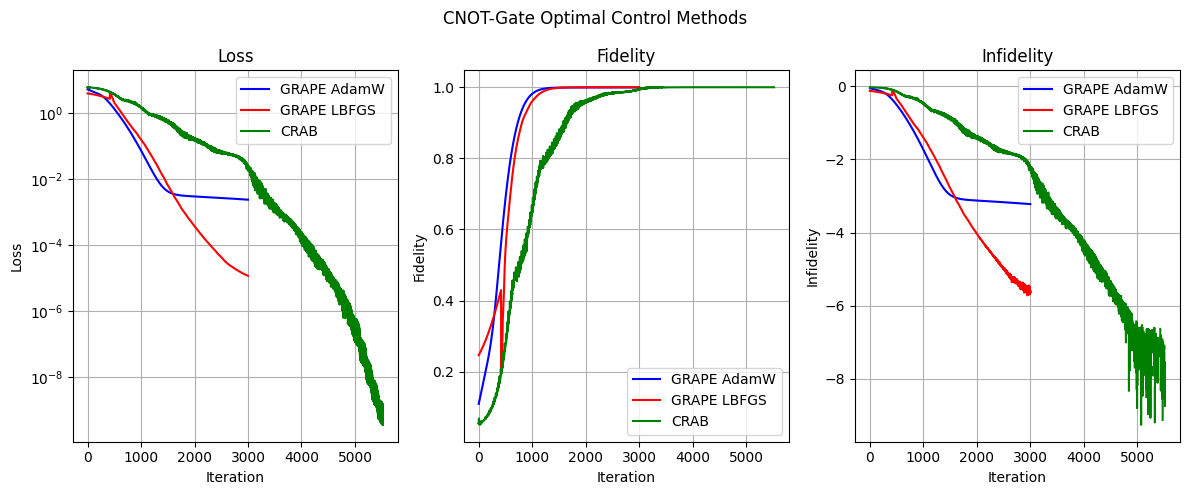

In [29]:
# plot loss, fid, inf
plt.figure(figsize=(12, 5))
plt.suptitle('CNOT-Gate Optimal Control Methods')
plt.subplot(1, 3, 1)
plt.plot(loss_list_grape_cnot_adam, label='GRAPE AdamW', color='blue')
plt.plot(loss_list_cnot_grape_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(loss_list_crab_cnot, label='CRAB', color='green')
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(fid_list_grape_cnot_adam, label='GRAPE AdamW', color='blue')
plt.plot(fid_list_cnot_grape_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(fid_list_crab_cnot, label='CRAB', color='green')
plt.title('Fidelity')
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.legend()
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(inf_list_grape_cnot_adam, label='GRAPE AdamW', color='blue')
plt.plot(inf_list_cnot_grape_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(inf_list_crab_cnot, label='CRAB', color='green')
plt.title('Infidelity')
plt.xlabel('Iteration')
plt.ylabel('Infidelity')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('/home/pdconte/Desktop/DUTh_Thesis/Plots/CNOT-Gate Optimal Control Methods.png')
plt.show()

In [30]:
pd.DataFrame({'loss_grape_cnot_adam': loss_list_grape_cnot_adam, 'fid_grape_cnot_adam': fid_list_grape_cnot_adam, 'inf_grape_cnot_adam': inf_list_grape_cnot_adam}).to_csv('grape_cnot_adam.csv')
pd.DataFrame({'loss_grape_cnot_lbfgs': loss_list_cnot_grape_lbfgs, 'fid_grape_cnot_lbfgs': fid_list_cnot_grape_lbfgs, 'inf_grape_cnot_lbfgs': inf_list_cnot_grape_lbfgs}).to_csv('grape_cnot_lbfgs.csv')
pd.DataFrame({'loss_crab_cnot': loss_list_crab_cnot, 'fid_crab_cnot': fid_list_crab_cnot, 'inf_crab_cnot': inf_list_crab_cnot}).to_csv('crab_cnot.csv')

In [31]:
u1x_grape_cnot_adam = u1x_grape_cnot_adam.detach().cpu().numpy()
u1z_grape_cnot_adam = u1z_grape_cnot_adam.detach().cpu().numpy()
u2x_grape_cnot_adam = u2x_grape_cnot_adam.detach().cpu().numpy()
u2z_grape_cnot_adam = u2z_grape_cnot_adam.detach().cpu().numpy()
coup_str_adam = jzx_grape_cnot_adam.detach().cpu().numpy()

In [32]:
u1x_grape_cnot_lbfgs = u1x_grape_cnot_lbfgs.detach().cpu().numpy()
u1z_grape_cnot_lbfgs = u1z_grape_cnot_lbfgs.detach().cpu().numpy()
u2x_grape_cnot_lbfgs = u2x_grape_cnot_lbfgs.detach().cpu().numpy()
u2z_grape_cnot_lbfgs = u2z_grape_cnot_lbfgs.detach().cpu().numpy()
coup_str_lbfgs = jzx_grape_cnot_lbfgs.detach().cpu().numpy()

In [33]:
coeff_drive1_opt    = res.x[0:2*K]
coeff_detuning1_opt = res.x[2*K:4*K]
coeff_drive2_opt    = res.x[4*K:6*K]
coeff_detuning2_opt = res.x[6*K:8*K]
coeff_coupling_opt = res.x[8*K:10*K]
time_edges = np.linspace(0, T_total, N+1)
u1x_crab_cnot = np.array([control_pulse(t, coeff_drive1_opt) for t in time_grid])
u1z_crab_cnot = np.array([control_pulse(t, coeff_detuning1_opt) for t in time_grid])
u2x_crab_cnot = np.array([control_pulse(t, coeff_drive2_opt) for t in time_grid])
u2z_crab_cnot = np.array([control_pulse(t, coeff_detuning2_opt) for t in time_grid])
coup_str_crab = np.array([control_pulse(t, coeff_coupling_opt) for t in time_grid])

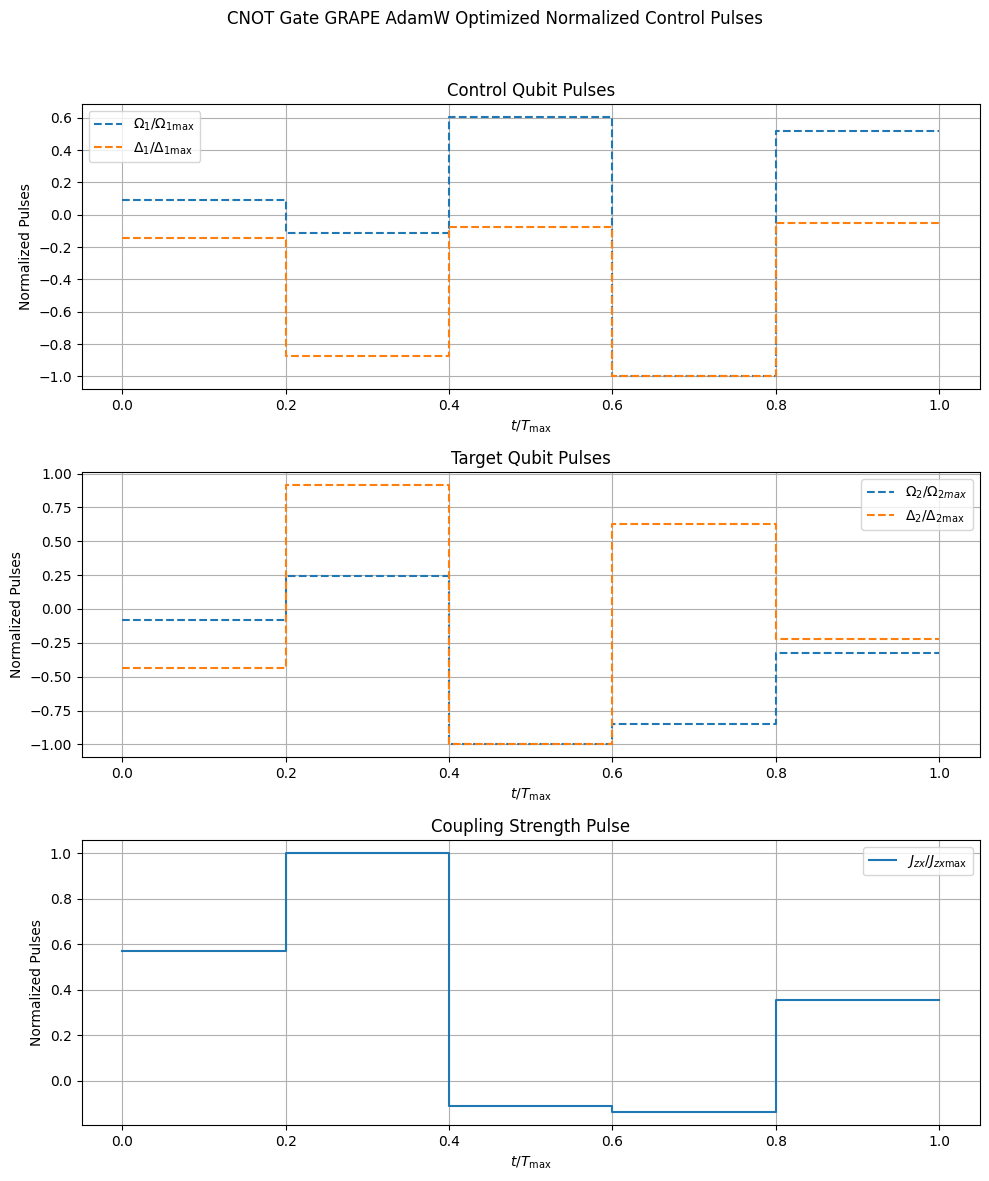

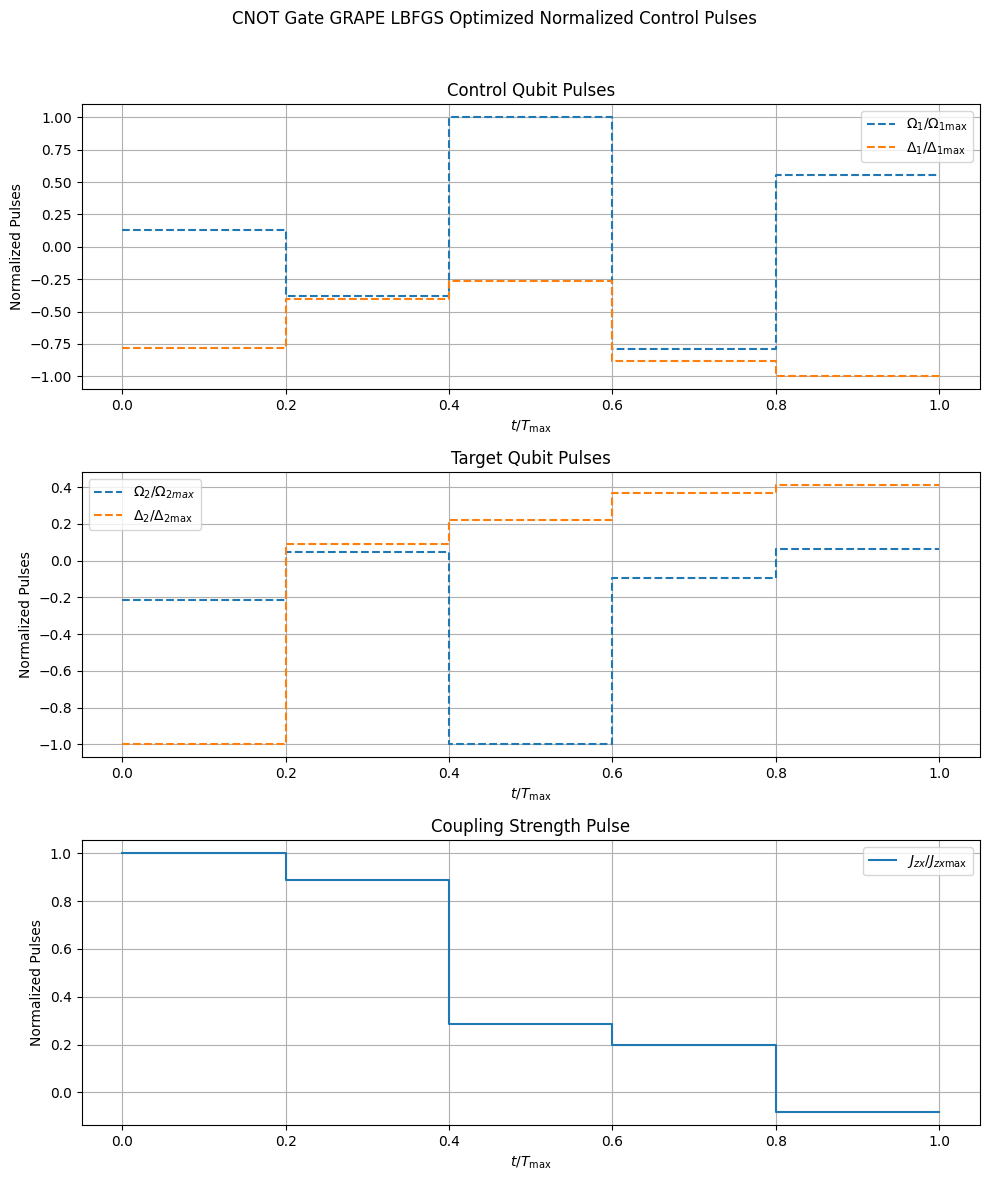

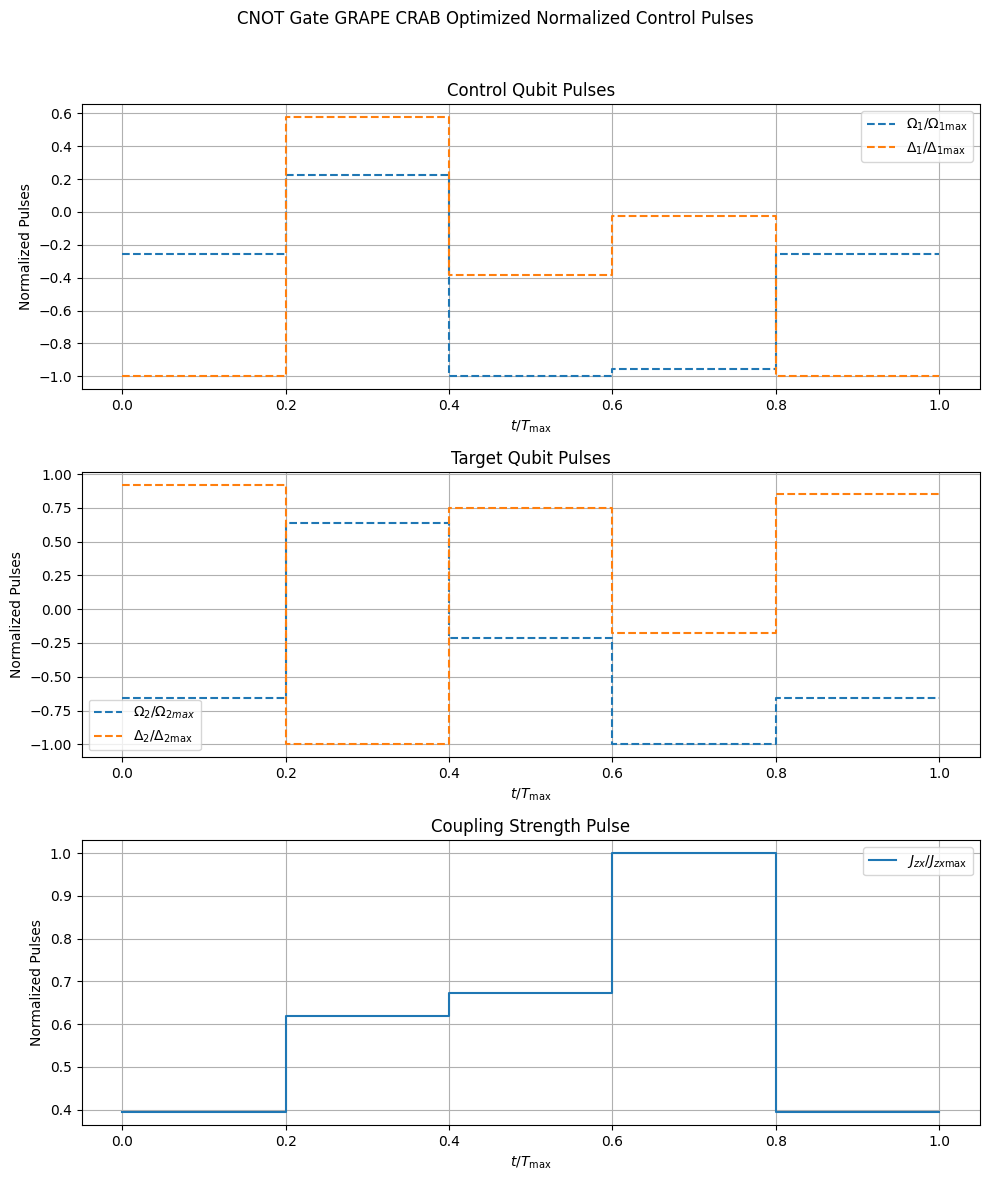

In [34]:
# Normalize the CNOT-gate data arrays
u1x_grape_cnot_adam_norm = normalize(u1x_grape_cnot_adam)
u1z_grape_cnot_adam_norm = normalize(u1z_grape_cnot_adam)
u2x_grape_cnot_adam_norm = normalize(u2x_grape_cnot_adam)
u2z_grape_cnot_adam_norm = normalize(u2z_grape_cnot_adam)
coup_str_adam_norm = normalize(coup_str_adam)
u1x_grape_cnot_lbfgs_norm = normalize(u1x_grape_cnot_lbfgs)
u1z_grape_cnot_lbfgs_norm = normalize(u1z_grape_cnot_lbfgs)
u2x_grape_cnot_lbfgs_norm = normalize(u2x_grape_cnot_lbfgs)
u2z_grape_cnot_lbfgs_norm = normalize(u2z_grape_cnot_lbfgs)
coup_str_lbfgs_norm = normalize(coup_str_lbfgs)
u1x_crab_cnot_norm = normalize(u1x_crab_cnot)
u1z_crab_cnot_norm = normalize(u1z_crab_cnot)
u2x_crab_cnot_norm = normalize(u2x_crab_cnot)
u2z_crab_cnot_norm = normalize(u2z_crab_cnot)
coup_str_crab_norm = normalize(coup_str_crab)

# Normalize the time axis: t/Tmax (Tmax is the final time value)
Tmax = time_edges[-1]
t_normalized = time_edges / Tmax

plt.figure(figsize=(10, 12))
plt.suptitle("CNOT Gate GRAPE AdamW Optimized Normalized Control Pulses")
plt.subplot(3, 1, 1)
plt.step(
    t_normalized,
    np.append(u1x_grape_cnot_adam_norm, u1x_grape_cnot_adam_norm[-1]),
    where="post",
    label=r"$\Omega_1/\Omega_{1\max}$",
    linestyle="--"
)
plt.step(
    t_normalized,
    np.append(u1z_grape_cnot_adam_norm, u1z_grape_cnot_adam_norm[-1]),
    where="post",
    label=r"$\Delta_1/\Delta_{1\max}$",
    linestyle="--",
)
plt.title(r"Control Qubit Pulses")
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel(r"Normalized Pulses")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.step(
    t_normalized,
    np.append(u2x_grape_cnot_adam_norm, u2x_grape_cnot_adam_norm[-1]),
    where="post",
    label=r"$\Omega_2/\Omega_{2max}$",
    linestyle="--",
)
plt.step(
    t_normalized,
    np.append(u2z_grape_cnot_adam_norm, u2z_grape_cnot_adam_norm[-1]),
    where="post",
    label=r"$\Delta_2/\Delta_{2\max}$",
    linestyle="--",
)
plt.title(r"Target Qubit Pulses")
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel(r"Normalized Pulses")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.step(
    t_normalized,
    np.append(coup_str_adam_norm, coup_str_adam_norm[-1]),
    where="post",
    label=r"$J_{zx} / J_{zx\max}$",
)
plt.title(r"Coupling Strength Pulse")
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel(r"Normalized Pulses")
plt.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.grid(True)
plt.savefig(
    "/home/pdconte/Desktop/DUTh_Thesis/Plots/CNOT_Gate_Optimal_Control_Pulses_Adam.png",
    dpi=300,
)

plt.figure(figsize=(10, 12))
plt.suptitle("CNOT Gate GRAPE LBFGS Optimized Normalized Control Pulses")
plt.subplot(3, 1, 1)
plt.step(
    t_normalized,
    np.append(u1x_grape_cnot_lbfgs_norm, u1x_grape_cnot_lbfgs_norm[-1]),
    where="post",
    label=r"$\Omega_1/\Omega_{1\max}$",
    linestyle="--",
)
plt.step(
    t_normalized,
    np.append(u1z_grape_cnot_lbfgs_norm, u1z_grape_cnot_lbfgs_norm[-1]),
    where="post",
    label=r"$\Delta_1/\Delta_{1\max}$",
    linestyle="--",
)
plt.title(r"Control Qubit Pulses")
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel(r"Normalized Pulses")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.step(
    t_normalized,
    np.append(u2x_grape_cnot_lbfgs_norm, u2x_grape_cnot_lbfgs_norm[-1]),
    where="post",
    label=r"$\Omega_2/\Omega_{2max}$",
    linestyle="--",
)
plt.step(
    t_normalized,
    np.append(u2z_grape_cnot_lbfgs_norm, u2z_grape_cnot_lbfgs_norm[-1]),
    where="post",
    label=r"$\Delta_2/\Delta_{2\max}$",
    linestyle="--",
)
plt.title(r"Target Qubit Pulses")
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel(r"Normalized Pulses")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.step(
    t_normalized,
    np.append(coup_str_lbfgs_norm, coup_str_lbfgs_norm[-1]),
    where="post",
    label=r"$J_{zx} / J_{zx\max}$",
)
plt.title(r"Coupling Strength Pulse")
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel(r"Normalized Pulses")
plt.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.grid(True)
plt.savefig(
    "/home/pdconte/Desktop/DUTh_Thesis/Plots/CNOT_Gate_Optimal_Control_Pulses_LBGS.png",
    dpi=300,
)
plt.figure(figsize=(10, 12))
plt.suptitle("CNOT Gate GRAPE CRAB Optimized Normalized Control Pulses")
plt.subplot(3, 1, 1)
plt.step(
    t_normalized,
    np.append(u1x_crab_cnot_norm, u1x_crab_cnot_norm[-1]),
    where="post",
    label=r"$\Omega_1/\Omega_{1\max}$",
    linestyle="--",
)
plt.step(
    t_normalized,
    np.append(u1z_crab_cnot_norm, u1z_crab_cnot_norm[-1]),
    where="post",
    label=r"$\Delta_1/\Delta_{1\max}$",
    linestyle="--",
)
plt.title(r"Control Qubit Pulses")
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel(r"Normalized Pulses")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.step(
    t_normalized,
    np.append(u2x_crab_cnot_norm, u2x_crab_cnot_norm[-1]),
    where="post",
    label=r"$\Omega_2/\Omega_{2max}$",
    linestyle="--",
)
plt.step(
    t_normalized,
    np.append(u2z_crab_cnot_norm, u2z_crab_cnot_norm[-1]),
    where="post",
    label=r"$\Delta_2/\Delta_{2\max}$",
    linestyle="--",
)
plt.title(r"Target Qubit Pulses")
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel(r"Normalized Pulses")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.step(
    t_normalized,
    np.append(coup_str_crab_norm, coup_str_crab_norm[-1]),
    where="post",
    label=r"$J_{zx} / J_{zx\max}$",
)
plt.title(r"Coupling Strength Pulse")
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel(r"Normalized Pulses")
plt.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.grid(True)
plt.savefig(
    "/home/pdconte/Desktop/DUTh_Thesis/Plots/CNOT_Gate_Optimal_Control_Pulses_CRAB.png",
    dpi=300,
)
plt.show()